<a href="https://colab.research.google.com/github/VatsalRaina01/Sentiment-analysis-with-BERT/blob/main/sentimentanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.40.0 which is incompatible.
84125825/84125825 [==============================] - 2s 0us/step


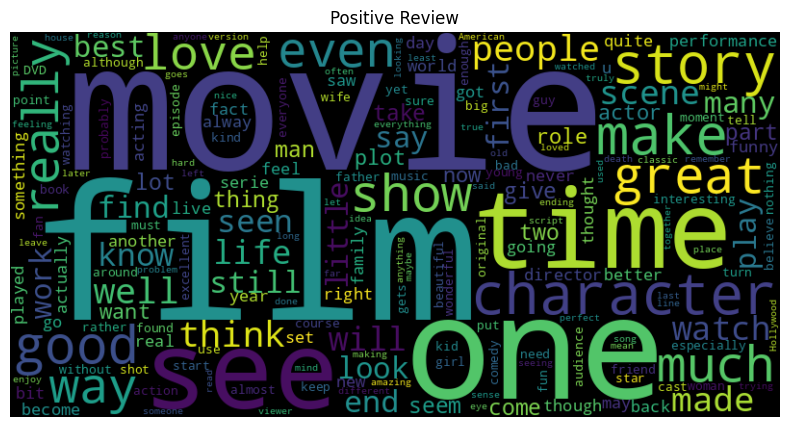

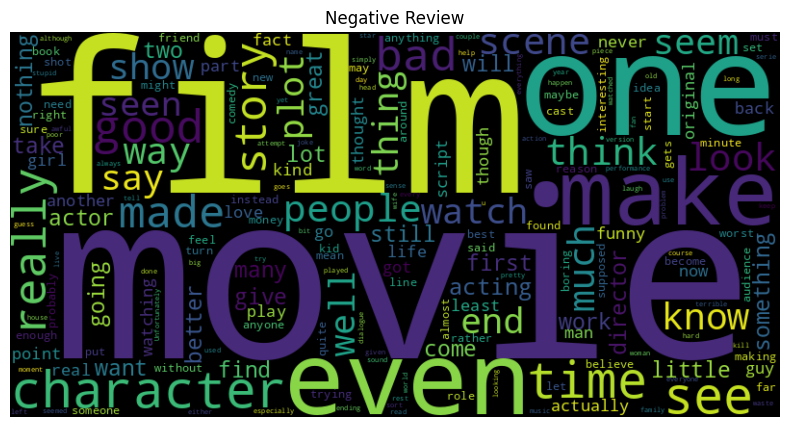

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Epoch 1/2
782/782 [==============================] - 429s 510ms/step - loss: 0.3314 - accuracy: 0.8572 - val_loss: 0.2975 - val_accuracy: 0.8728
Epoch 2/2
391/391 [==============================] - 60s 153ms/step - loss: 0.3207 - accuracy: 0.8657
Test loss: 0.3207157254219055, Test accuracy: 0.8656799793243408


Some layers from the model checkpoint at /content/Model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/Model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1/1 [==============================] - 3s 3s/step
['positive']


In [1]:
!pip install transformers==4.40.0 plotly wordcloud bs4

import os
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Download dataset
current_folder = os.getcwd()
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=current_folder,
    extract=True
)

dataset_path = os.path.dirname(dataset)
dataset_dir = os.path.join(dataset_path, 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

# Load dataset
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        if file_name == 'pos':
            for text_file in os.listdir(os.path.join(directory, file_name)):
                with open(os.path.join(directory, file_name, text_file), "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            for text_file in os.listdir(os.path.join(directory, file_name)):
                with open(os.path.join(directory, file_name, text_file), "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)
    return pd.DataFrame(data)

train_df = load_dataset(train_dir)
test_df = load_dataset(test_dir)

# Plot sentiment counts
sentiment_counts = train_df['sentiment'].value_counts()
fig = px.bar(
    x={0: 'Negative', 1: 'Positive'},
    y=sentiment_counts.values,
    color=sentiment_counts.index,
    color_discrete_sequence=px.colors.qualitative.Dark24,
    title='<b>Sentiment Counts'
)
fig.update_layout(template='plotly_dark')
pyo.plot(fig, filename='Sentiments_Counts.html', auto_open=True)

# Clean text
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    text = re.sub(r"[^a-zA-Z0-9\s,']", '', text)
    return text

train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning)
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

# Word clouds
def generate_wordcloud(text, title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800, height=400, stopwords=set(STOPWORDS), background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_wordcloud(train_df[train_df['sentiment']==1]['Cleaned_sentence'], 'Positive Review')
generate_wordcloud(train_df[train_df['sentiment']==0]['Cleaned_sentence'], 'Negative Review')

# Prepare train/val/test
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

x_val, x_test, y_val, y_test = train_test_split(test_reviews, test_targets, test_size=0.5, stratify=test_targets)

# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

max_len = 128
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')
X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')
X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), padding=True, truncation=True, max_length=max_len, return_tensors='tf')

# Model (TF-ready)
model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased-finetuned-sst-2-english',
    num_labels=2,
    from_pt=False
)

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train
history = model.fit(
    [X_train_encoded['input_ids'], X_train_encoded['attention_mask']],
    Target,
    validation_data=([X_val_encoded['input_ids'], X_val_encoded['attention_mask']], y_val),
    batch_size=32,
    epochs=2
)

# Evaluate
test_loss, test_accuracy = model.evaluate(
    [X_test_encoded['input_ids'], X_test_encoded['attention_mask']],
    y_test
)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}')

# Save
path = '/content'
tokenizer.save_pretrained(path + '/Tokenizer')
model.save_pretrained(path + '/Model')

# Load back
distil_tokenizer = DistilBertTokenizer.from_pretrained(path + '/Tokenizer')
distil_model = TFDistilBertForSequenceClassification.from_pretrained(path + '/Model', from_pt=False)

# Prediction example
def Get_sentiment(Review, Tokenizer=distil_tokenizer, Model=distil_model):
    if not isinstance(Review, list):
        Review = [Review]
    encoded = Tokenizer.batch_encode_plus(Review, padding=True, truncation=True, max_length=128, return_tensors='tf')
    prediction = Model.predict([encoded['input_ids'], encoded['attention_mask']])
    label_map = {1: 'positive', 0: 'negative'}
    pred_labels = tf.argmax(prediction.logits, axis=1).numpy().tolist()
    return [label_map[i] for i in pred_labels]

Review = """Bahubali is a blockbuster Indian movie that was released in 2015.
It is the first part of a two-part epic saga that tells the story of a legendary hero who fights for his kingdom and his love.
The movie has received rave reviews from critics and audiences alike for its stunning visuals, spectacular action scenes, and captivating storyline."""
print(Get_sentiment(Review))
